<a href="https://colab.research.google.com/github/NP-15/Machine-learning/blob/main/Sessions/Self-Organising-Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identifying style of driver

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10650 sha256=ccf4b79cfe69832ead5c5049a9128743472841b2f627ee9b83e3be081350e229
  Stored in directory: /root/.cache/pip/wheels/b4/f6/8a/9daf8831901c3e3805775633404248f10663d1c80b7e5a1314
Successfully built minisom


In [11]:
from minisom import MiniSom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [12]:
speed = [random.randint(40, 80) for i in range(80)]
acceleration = [random.uniform(1, 2) for i in range(80)]
braking = [random.uniform(0, 1) for i in range(80)]
steering_angle = [random.randint(1, 90) for i in range(80)]

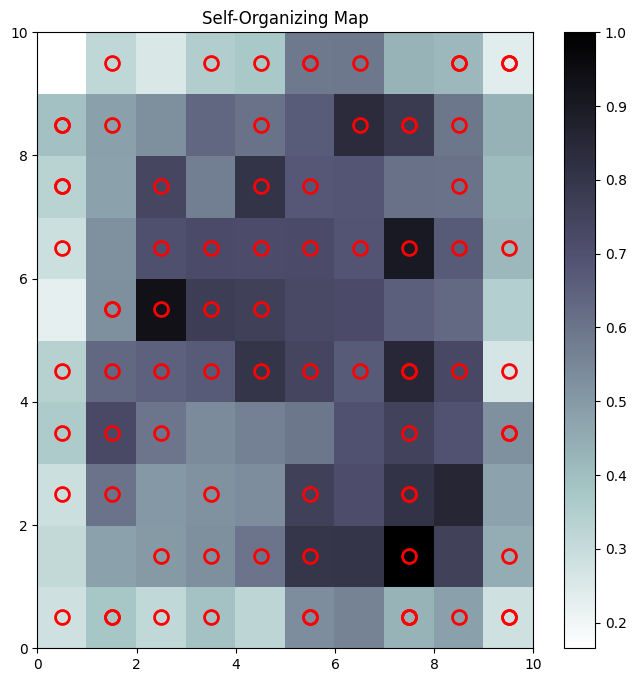

In [13]:
data = pd.DataFrame({
    "speed" : speed,
    "acceleration" : acceleration,
    "braking" : braking,
    "steering_angle" : steering_angle
})

X = data[['speed', 'acceleration', 'braking', 'steering_angle']].values

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

som = MiniSom(x=10, y=10, input_len=4, sigma=1.0, learning_rate=0.5)

som.random_weights_init(X)
som.train_random(X, 1000)

plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

for i, x in enumerate(X):
    w = som.winner(x)
    plt.plot(w[0] + 0.5, w[1] + 0.5, 'ro', markerfacecolor='None', markersize=10, markeredgewidth=2)

plt.title('Self-Organizing Map')
plt.show()

## Canonical Correlation Analysis

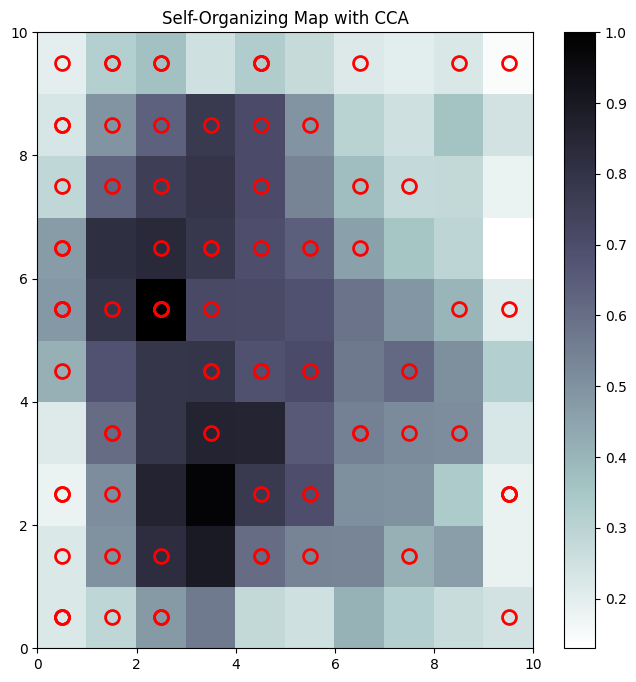

In [14]:
from sklearn.cross_decomposition import CCA

data = pd.DataFrame({
    "speed" : speed,
    "acceleration" : acceleration,
    "braking" : braking,
    "steering_angle" : steering_angle
})

X = data[['speed', 'acceleration', 'braking', 'steering_angle']].values
Y = data[['speed', 'acceleration', 'braking', 'steering_angle']].values

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
Y = (Y - Y.min(axis=0)) / (Y.max(axis=0) - Y.min(axis=0))

cca = CCA(n_components=2)
cca.fit(X, Y)

X_c, Y_c = cca.transform(X, Y)

som = MiniSom(x=10, y=10, input_len=2, sigma=1.0, learning_rate=0.5)

som.random_weights_init(X_c)
som.train_random(X_c, 1000)

plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

for i, x in enumerate(X_c):
    w = som.winner(x)
    plt.plot(w[0] + 0.5, w[1] + 0.5, 'ro', markerfacecolor='None', markersize=10, markeredgewidth=2)

plt.title('Self-Organizing Map with CCA')
plt.show()


## ASSOM

In [15]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

class ASSOM:
    def __init__(self, x_dim, y_dim, input_dim, num_epochs=100, learning_rate=0.1, radius=1.0):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.input_dim = input_dim
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.radius = radius

        self.weights = np.random.rand(x_dim * y_dim, input_dim)

    def find_bmu(self, x):
        distances = euclidean_distances(x.reshape(1, -1), self.weights)
        bmu_index = np.argmin(distances)
        return np.unravel_index(bmu_index, (self.x_dim, self.y_dim))

    def update_weights(self, x, bmu):
        distances = np.sqrt(np.sum((np.array(bmu) - np.array([[i, j] for i in range(self.x_dim) for j in range(self.y_dim)])) ** 2, axis=1))
        neighborhood = np.exp(-distances / (2 * self.radius ** 2))

        self.weights += self.learning_rate * neighborhood[:, np.newaxis] * (x - self.weights)

    def fit(self, X):
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        for epoch in range(self.num_epochs):
            for x in X_scaled:
                bmu = self.find_bmu(x)
                self.update_weights(x, bmu)

            self.learning_rate *= 0.95
            self.radius *= 0.95

    def predict(self, X):
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        bmus = [self.find_bmu(x) for x in X_scaled]
        return bmus

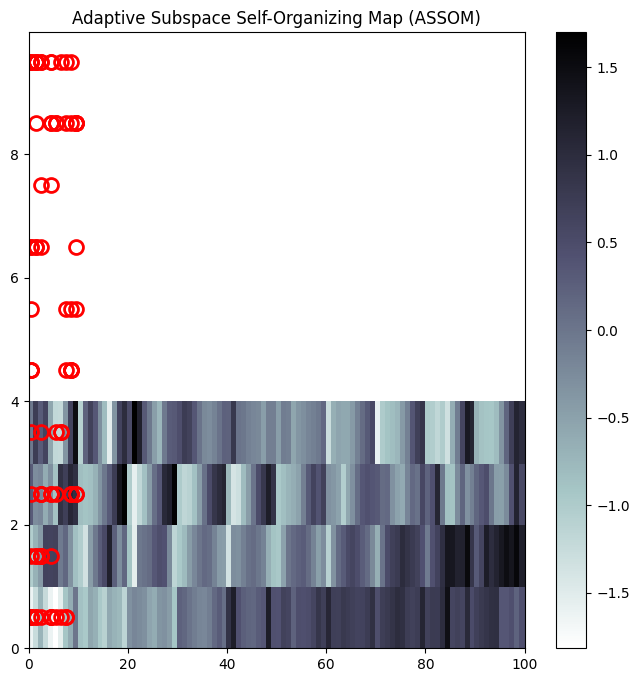

In [16]:
data = pd.DataFrame({
    "speed" : speed,
    "acceleration" : acceleration,
    "braking" : braking,
    "steering_angle" : steering_angle
})

X = data[['speed', 'acceleration', 'braking', 'steering_angle']].values

assom = ASSOM(x_dim=10, y_dim=10, input_dim=4, num_epochs=100)
assom.fit(X)

plt.figure(figsize=(8, 8))
plt.pcolor(assom.weights.T, cmap='bone_r')
plt.colorbar()

for bmu in assom.predict(X):
    plt.plot(bmu[0] + 0.5, bmu[1] + 0.5, 'ro', markerfacecolor='None', markersize=10, markeredgewidth=2)

plt.title('Adaptive Subspace Self-Organizing Map (ASSOM)')
plt.show()